In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans

import seaborn as sns 
sns.set()
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from joblib import dump

In [2]:
#Load data
df = pd.read_csv('/home/soukaina/Downloads/BankChurners.csv')


# Create Model and Cluster Data

In [3]:
df.drop(df.iloc[:, 21:24],axis = 1,inplace=True)

In [4]:
#Take all the numerical data
cols = df.iloc[:, 9:].select_dtypes(['uint8', 'int64', 'float64']).columns
cols

Index(['Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'],
      dtype='object')

## Use Elbow methode to identify k value 

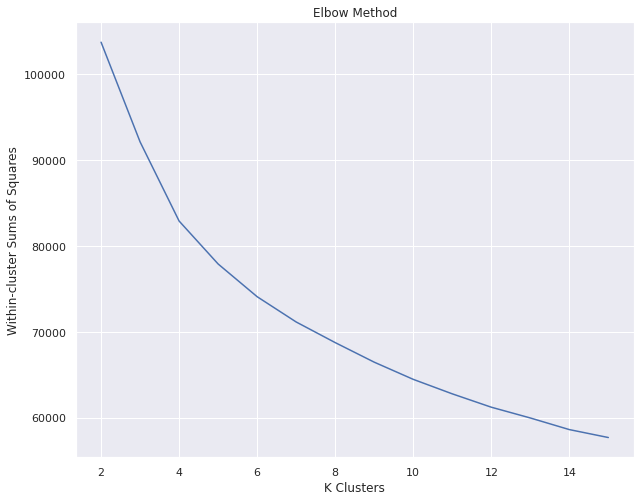

In [5]:
wcss = []

for i in range(2,16):
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 500, n_init = 10, random_state = 1)
    data = StandardScaler().fit_transform(df[cols])
    km.fit(data)
    wcss.append(km.inertia_)

fig = plt.figure(figsize=(10,8))
plt.plot(range(2,16), wcss)
plt.title('Elbow Method')
plt.xlabel('K Clusters')
plt.ylabel('Within-cluster Sums of Squares')
plt.show()


# Create a pipeline 

###  Perform Principal Component Analysis(PCA)

In [6]:
preprocessor = Pipeline(
[
 ("scaler", StandardScaler()),
 ("pca", PCA(n_components=2, random_state=1))
]
)

clusterer = Pipeline(
     [
       (
              "kmeans",
               KMeans(
                   n_clusters=6,
                   init="k-means++",
                   n_init=50,
                   max_iter=1000,
                   random_state=1
                      )
       )
      ]
   )

pipe = Pipeline(
        [
            ("preprocessor", preprocessor),
            ("clusterer", clusterer)
        ]
    )


pipe.fit(df[cols])

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('scaler', StandardScaler()),
                                 ('pca',
                                  PCA(n_components=2, random_state=1))])),
                ('clusterer',
                 Pipeline(steps=[('kmeans',
                                  KMeans(max_iter=1000, n_clusters=6, n_init=50,
                                         random_state=1))]))])

In [7]:
dump(pipe,'model_joblib.joblib')

['model_joblib.joblib']

### Calculate Silhouette Score

In [12]:
preprocessed_data = pipe["preprocessor"].transform(df[cols])

predicted_labels = pipe["clusterer"]["kmeans"].labels_

print('Silhouette Score: ', round(silhouette_score(preprocessed_data, predicted_labels), 3))

Silhouette Score:  0.395


#  clusters on a scatterplot

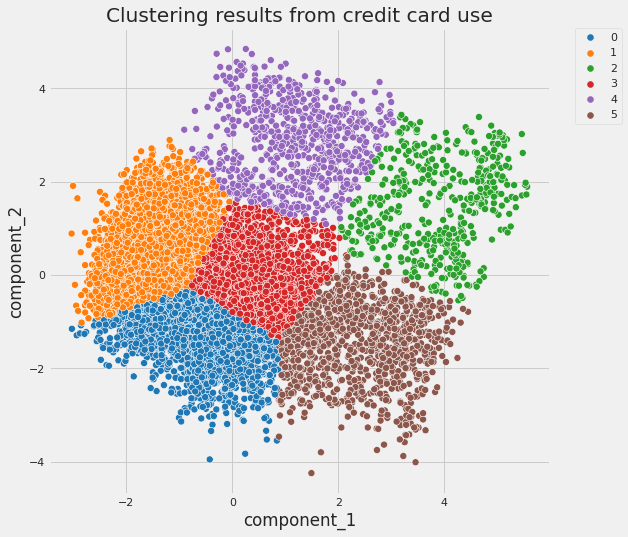

In [13]:
pcadf = pd.DataFrame(
        pipe["preprocessor"].transform(df[cols]),
        columns=["component_1", "component_2"]
    )
   
pcadf["predicted_cluster"] = pipe["clusterer"]["kmeans"].labels_

plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 8))
   
sp = sns.scatterplot(
        x="component_1",
        y="component_2",
        s=50,
        data=pcadf,
        hue="predicted_cluster",
        palette='tab10'
    )
   
sp.set_title(
        "Clustering results from credit card use"
    )
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
   
plt.show()

In [17]:
df['cluster'] = pipe['clusterer']['kmeans'].labels_


###  Analyse how many people are in each cluster

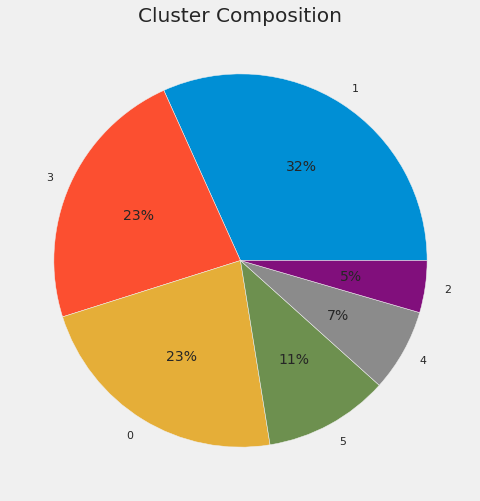

In [18]:
fig, axs = plt.subplots(figsize=(12,8))
ax = df['cluster'].value_counts().plot.pie(title='Cluster Composition', autopct='%1.0f%%')
plt.title=False
ax.set_ylabel('')
plt.show()

# Examine Differences Between Clusters

<AxesSubplot:title={'center':'Group 6'}>

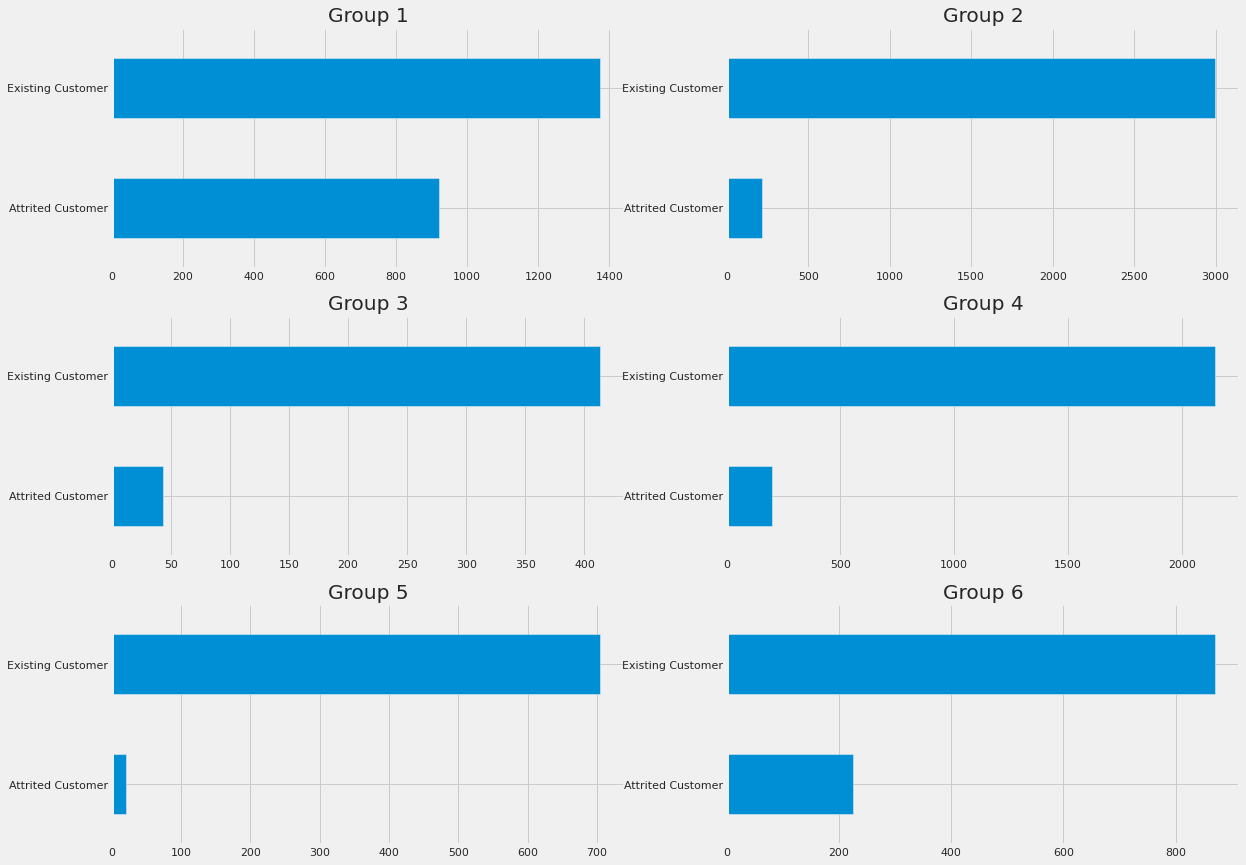

In [19]:
fig, axs = plt.subplots(ncols=2,nrows=3, figsize=(18,14))

df[df['cluster'] == 0]['Attrition_Flag'].value_counts().sort_index().plot.barh(ax=axs[0,0], title='Group 1')
df[df['cluster'] == 1]['Attrition_Flag'].value_counts().sort_index().plot.barh(ax=axs[0,1], title='Group 2')
df[df['cluster'] == 2]['Attrition_Flag'].value_counts().sort_index().plot.barh(ax=axs[1,0], title='Group 3')
df[df['cluster'] == 3]['Attrition_Flag'].value_counts().sort_index().plot.barh(ax=axs[1,1], title='Group 4')
df[df['cluster'] == 4]['Attrition_Flag'].value_counts().sort_index().plot.barh(ax=axs[2,0], title='Group 5')
df[df['cluster'] == 5]['Attrition_Flag'].value_counts().sort_index().plot.barh(ax=axs[2,1], title='Group 6')



## Age

[Text(0.5, 1.0, 'High limit, low balance heavy users'),
 Text(0, 0.5, ''),
 Text(0.5, 0, '')]

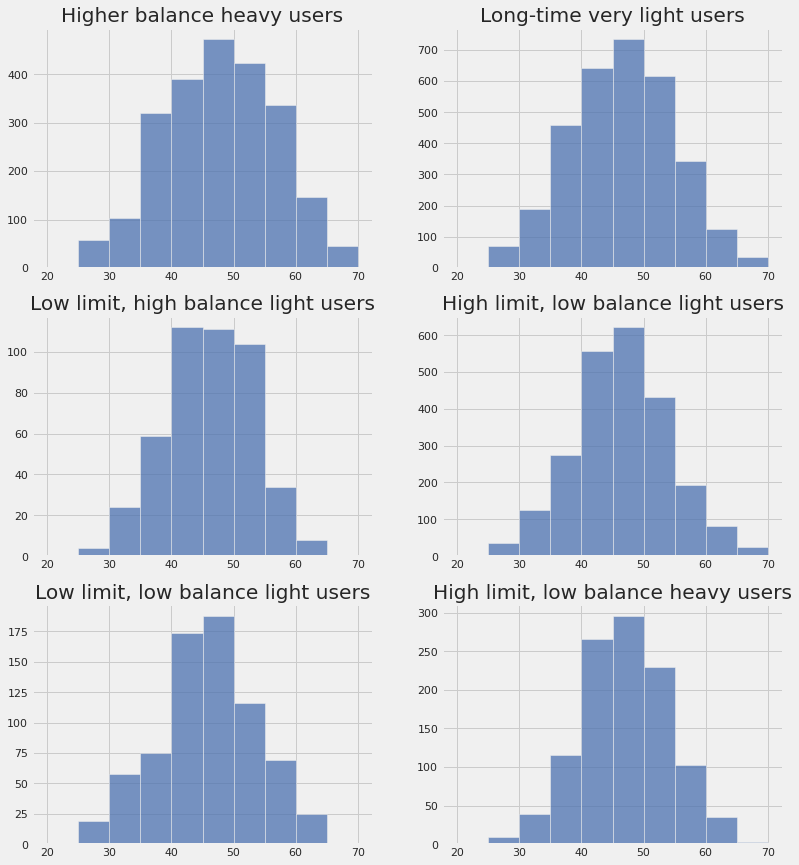

In [21]:
fig, axs = plt.subplots(ncols=2,nrows=3, figsize=(12,14))

sns.histplot(df[df['cluster'] == 0]['Customer_Age'], ax=axs[0,0], binrange=(20,70), binwidth=5).set(title='Higher balance heavy users', ylabel='', xlabel='')
sns.histplot(df[df['cluster'] == 1]['Customer_Age'], ax=axs[0,1], binrange=(20,70), binwidth=5).set(title='Long-time very light users', ylabel='', xlabel='')
sns.histplot(df[df['cluster'] == 2]['Customer_Age'], ax=axs[1,0], binrange=(20,70), binwidth=5).set(title='Low limit, high balance light users', ylabel='', xlabel='')
sns.histplot(df[df['cluster'] == 3]['Customer_Age'], ax=axs[1,1], binrange=(20,70), binwidth=5).set(title='High limit, low balance light users', ylabel='', xlabel='')
sns.histplot(df[df['cluster'] == 4]['Customer_Age'], ax=axs[2,0], binrange=(20,70), binwidth=5).set(title='Low limit, low balance light users', ylabel='', xlabel='')
sns.histplot(df[df['cluster'] == 5]['Customer_Age'], ax=axs[2,1], binrange=(20,70), binwidth=5).set(title='High limit, low balance heavy users', ylabel='', xlabel='')


## Gender

<AxesSubplot:title={'center':'High limit, low balance heavy users'}>

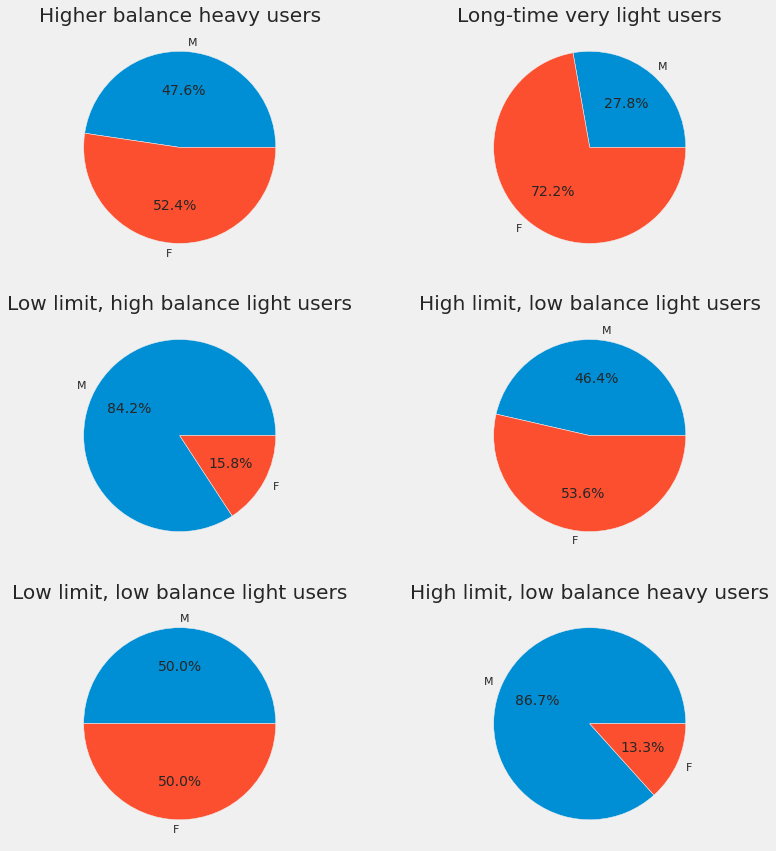

In [22]:
fix, axs = plt.subplots(ncols=2,nrows=3, figsize=(12,14))

df[df['cluster'] == 0]['Gender'].value_counts().sort_index(ascending=False).plot.pie(ax=axs[0,0], ylabel='', title='Higher balance heavy users', autopct='%.1f%%')
df[df['cluster'] == 1]['Gender'].value_counts().sort_index(ascending=False).plot.pie(ax=axs[0,1], ylabel='', title='Long-time very light users', autopct='%.1f%%')
df[df['cluster'] == 2]['Gender'].value_counts().sort_index(ascending=False).plot.pie(ax=axs[1,0], ylabel='', title='Low limit, high balance light users', autopct='%.1f%%')
df[df['cluster'] == 3]['Gender'].value_counts().sort_index(ascending=False).plot.pie(ax=axs[1,1], ylabel='', title='High limit, low balance light users', autopct='%.1f%%')
df[df['cluster'] == 4]['Gender'].value_counts().sort_index(ascending=False).plot.pie(ax=axs[2,0], ylabel='', title='Low limit, low balance light users', autopct='%.1f%%')
df[df['cluster'] == 5]['Gender'].value_counts().sort_index(ascending=False).plot.pie(ax=axs[2,1], ylabel='', title='High limit, low balance heavy users', autopct='%.1f%%')

## Marital Status

<AxesSubplot:title={'center':'High limit, low balance heavy users'}>

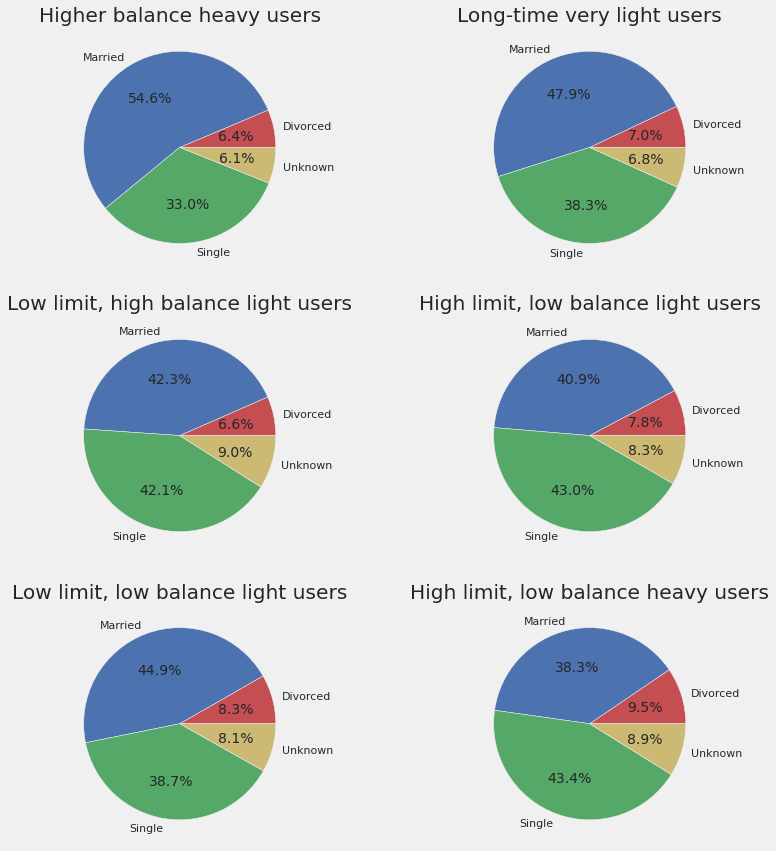

In [24]:
fix, axs = plt.subplots(ncols=2,nrows=3, figsize=(12,14))

df[df['cluster'] == 0]['Marital_Status'].value_counts().sort_index().plot(kind='pie', ax=axs[0,0], ylabel='', title='Higher balance heavy users', colors=['r','b','g','y'], autopct='%.1f%%')
df[df['cluster'] == 1]['Marital_Status'].value_counts().sort_index().plot(kind='pie', ax=axs[0,1], ylabel='', title='Long-time very light users', colors=['r','b','g','y'], autopct='%.1f%%')
df[df['cluster'] == 2]['Marital_Status'].value_counts().sort_index().plot(kind='pie', ax=axs[1,0], ylabel='', title='Low limit, high balance light users', colors=['r','b','g','y'], autopct='%.1f%%')
df[df['cluster'] == 3]['Marital_Status'].value_counts().sort_index().plot(kind='pie', ax=axs[1,1], ylabel='', title='High limit, low balance light users', colors=['r','b','g','y'], autopct='%.1f%%')
df[df['cluster'] == 4]['Marital_Status'].value_counts().sort_index().plot(kind='pie', ax=axs[2,0], ylabel='', title='Low limit, low balance light users', colors=['r','b','g','y'], autopct='%.1f%%')
df[df['cluster'] == 5]['Marital_Status'].value_counts().sort_index().plot(kind='pie', ax=axs[2,1], ylabel='', title='High limit, low balance heavy users', colors=['r','b','g','y'], autopct='%.1f%%')

## Income Level

<AxesSubplot:title={'center':'High limit, low balance heavy users'}>

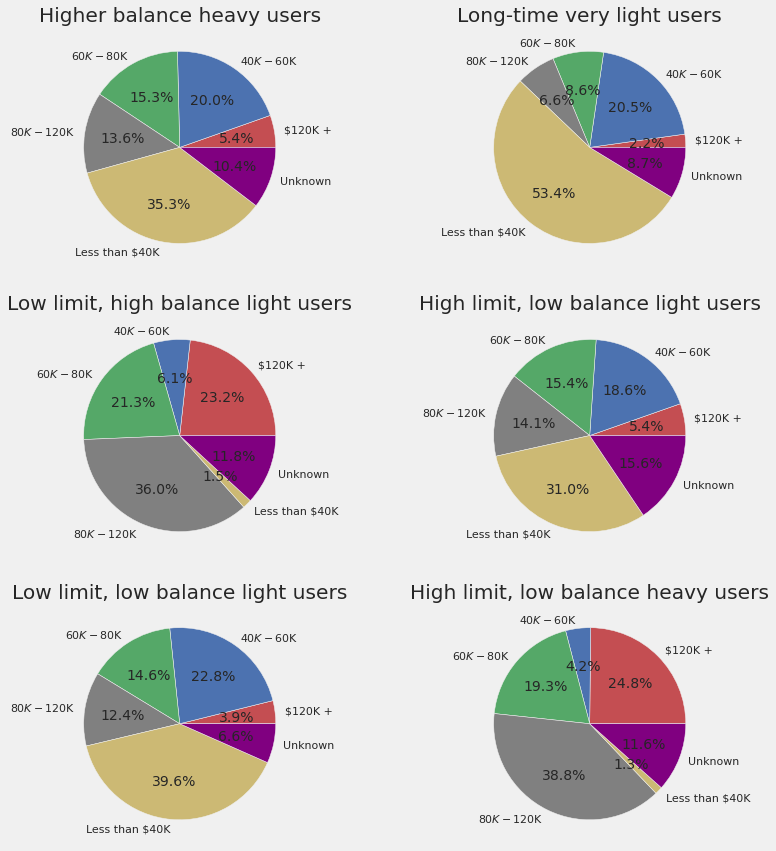

In [23]:
fix, axs = plt.subplots(ncols=2,nrows=3, figsize=(12,14))

df[df['cluster'] == 0]['Income_Category'].value_counts().sort_index().plot(kind='pie', ax=axs[0,0], ylabel='', title='Higher balance heavy users', colors=['r','b','g','gray','y','purple'], autopct='%.1f%%')
df[df['cluster'] == 1]['Income_Category'].value_counts().sort_index().plot(kind='pie', ax=axs[0,1], ylabel='', title='Long-time very light users', colors=['r','b','g','gray','y','purple'], autopct='%.1f%%')
df[df['cluster'] == 2]['Income_Category'].value_counts().sort_index().plot(kind='pie', ax=axs[1,0], ylabel='', title='Low limit, high balance light users', colors=['r','b','g','gray','y','purple'], autopct='%.1f%%')
df[df['cluster'] == 3]['Income_Category'].value_counts().sort_index().plot(kind='pie', ax=axs[1,1], ylabel='', title='High limit, low balance light users', colors=['r','b','g','gray','y','purple'], autopct='%.1f%%')
df[df['cluster'] == 4]['Income_Category'].value_counts().sort_index().plot(kind='pie', ax=axs[2,0], ylabel='', title='Low limit, low balance light users', colors=['r','b','g','gray','y','purple'], autopct='%.1f%%')
df[df['cluster'] == 5]['Income_Category'].value_counts().sort_index().plot(kind='pie', ax=axs[2,1], ylabel='', title='High limit, low balance heavy users', colors=['r','b','g','gray','y','purple'], autopct='%.1f%%')